# SAN model

In [1]:
%%capture
! pip install torchinfo

In [2]:
%%capture
! wget https://raw.githubusercontent.com/harshraj22/DeepLearning/main/implementations/SAN/models/attention.py
! wget https://raw.githubusercontent.com/harshraj22/DeepLearning/main/implementations/SAN/models/image_encoder.py
! wget https://raw.githubusercontent.com/harshraj22/DeepLearning/main/implementations/SAN/models/question_encoder.py
! wget https://raw.githubusercontent.com/harshraj22/DeepLearning/main/implementations/SAN/models/san.py
! wget https://raw.githubusercontent.com/harshraj22/DeepLearning/main/implementations/SAN/utils/dataset.py

In [3]:
import gc
gc.collect()

109

In [4]:
import torch
import torch.nn as nn

# from attention import AttentionLayer
from image_encoder import ImageEncoder
# from question_encoder import QuestionEncoder
# from san import SAN

import warnings
warnings.filterwarnings("ignore")

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms


class QuestionEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, out_size):
        super(QuestionEncoder, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.out_size = out_size

        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        self.lstm = nn.LSTM(self.embed_size, self.out_size, batch_first=True)

    def forward(self, x):
        """Implements the class to encode the questions into feature vectors. Uses embeddings and LSTMs for the same
        
        Args:
            x (N, seq_len): Tensor containing numbers corresponding to words of the sentence.
        
        Returns:
            c (N, out_size): Feature vector corresponding to each question vector
        """
        output, (h, c) = self.lstm(self.embed(x))
        return torch.squeeze(h, dim=0)


if __name__ == '__main__':
    vocab_size, embed_size, out_size = 500, 250, 90
    model = QuestionEncoder(vocab_size, embed_size, out_size)
    # batch of 2 sentences, each containing 4 words
    sentence = torch.tensor([
                             [1, 2, 3, 4],
                             [5, 6, 7, 8]
    ])
    out = model(sentence)
    assert tuple(out.shape) == (2, out_size)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Attention(nn.Module):
	def __init__(self, hidden_dim, img_dim, ques_dim):
		super(Attention, self).__init__()
		self.w1 = nn.Linear(img_dim, hidden_dim, bias=False)
		self.w2 = nn.Linear(ques_dim, hidden_dim)
		self.wp = nn.Linear(hidden_dim, 1)
		self.tanh = torch.tanh
	
	def forward(self, vi, vq):
		"""
		Summary: 
			d = img_dim = ques_dim
		Args:
			vi (m, d): Visual features of the image, where m = (width * height) of feature map
			vq (d):    Features of the question

		Returns:
			pi (m): Attention coeeficient (alpha) corresponding to each feature vector
		"""
		assert vi.shape[-1] == vq.shape[-1], "Dimentions of Vi and Vq don't match during Attention"
		a = self.w1(vi)
		# vq = vq / 800
		# norm = transforms.Normalize((0.5, 0.5), (0.5, 0.5))
		# vq = F.normalize(vq)
		# unsqueeze for adding vector to matrix.
		# read about broadcasting: https://pytorch.org/docs/stable/notes/broadcasting.html
		b = torch.unsqueeze(self.w2(vq), -2)
		# h.shape: (m, hidden_dim)
		h = self.tanh(a + b)
		# print(f'Attention: a: {a},\n vq: {vq} b: {b},\n h: {h}, wp(h): {self.wp(h)}')
		# pi.shape: (m, 1)
		pi = F.softmax(self.wp(h), dim=1)
        # print(f'Pi: {pi}')
		return pi
	
	
class AttentionLayer(nn.Module):
	def __init__(self, hidden_dim, img_dim, ques_dim):
		super(AttentionLayer, self).__init__()
		self.attention = Attention(hidden_dim, img_dim, ques_dim)

	def forward(self, vi, u):
		"""Implements Stacked Attention Layer. Question feature 'u' is repeatedly passed through this layer,
		it calculates the attention over the image features, and merges the features into itself.

		Args:
			vi (m, d): Visual features of image, where m = (width * height) of feature map
			u (d):     Features of the question

		Returns:
			u (d): Features of question after applying the attention over the image
		"""
		pi = self.attention(vi, u)
		# assert pi.shape[1] == vi.shape[1], f"pi ({pi.shape}) and vi ({vi.shape}) don't have same shape in AttentionLayer"
		u = torch.sum(pi * vi) + torch.unsqueeze(u, dim=-2)

		# print(f'pi:{pi.shape} {pi}\nU: {u.shape} {u}')
		return torch.squeeze(u, dim=-2)
	
	
# if __name__ == '__main__':
# 	m, d, hidden_dim = (14 * 14), 120, 53
# 	bs = 2

# 	vi = torch.rand((bs, m, d))
# 	u = torch.rand((bs, d))

# 	model = Attention(hidden_dim, d, d)
# 	out = model(vi, u)

# 	assert out.shape == (bs, m, 1)


In [7]:
import torch
import torch.nn as nn

# from attention import AttentionLayer
from image_encoder import ImageEncoder
from question_encoder import QuestionEncoder



class SAN(nn.Module):
  def __init__(self, feat_dim, vocab_size, embed_size, n_attention_stacks, hidden_dim_img):
    super(SAN, self).__init__()
    self.feat_dim = feat_dim
    self.vocab_size = vocab_size
    self.embed_size = embed_size

    self.img_enc = ImageEncoder(feat_dim)
    self.ques_enc = QuestionEncoder(vocab_size, embed_size, feat_dim)
    self.att = nn.ModuleList([
              AttentionLayer(hidden_dim_img, feat_dim, feat_dim) for _ in range(n_attention_stacks)
    ])

    self.pred = nn.Linear(feat_dim, vocab_size)


  def forward(self, img, ques):
    """Returns one word output corresponding to input image and question
    
    Args:
        img (N, 3, 448, 448): Image of given shape, constrained due to use of vgg
        ques (N, seq_len): Question encoded as integers
    
    Returns:
        u (N, vocab_size): Vectors of vocab_size, for picking the most probable word
    """

    img = self.img_enc(img)
    img = F.normalize(img)
    ques = self.ques_enc(ques)
    ques = F.normalize(ques)
    
    u = ques
    for layer in self.att:
      u = layer(img, u)
      u = F.normalize(u)
    return self.pred(u)



# if __name__ == '__main__':
#     vocab_size = 500
#     seq_len = 12
#     feat_dim = 600
#     embed_size = 250
#     n_attention_stacks = 5
#     hidden_dim_img = 32

#     model = SAN(feat_dim, vocab_size, embed_size, n_attention_stacks, hidden_dim_img)
#     img = torch.rand((1, 3, 448, 448))
#     ques = torch.randint(0, vocab_size, (1, seq_len))
#     out = model(img, ques)
#     assert tuple(out.shape) == (1, vocab_size)




In [8]:
vocab_size = 9000 # from bert
seq_len = 12 # from dataset
feat_dim = 640 # from paper, the final vector vq, vi
embed_size = 500 # from paper, dimention of embedding of each word
n_attention_stacks = 5
hidden_dim_img = feat_dim
batch_size = 10

In [9]:
model = SAN(feat_dim, vocab_size, embed_size, n_attention_stacks, hidden_dim_img)
img = torch.rand((batch_size, 3, 448, 448))
img = torch.randint(0, 255, (batch_size, 3, 448, 448)).float()
ques = torch.randint(0, vocab_size, (batch_size, seq_len), dtype=torch.int32)
out = model(img, ques)
assert tuple(out.shape) == (batch_size, vocab_size)

In [27]:
from torchinfo import summary
# summary(model, input_size=[(1, 3, 448, 448), (1, seq_len,)], input_data=[torch.float32, torch.float32])
summary(model, input_data=[img, ques])

Layer (type:depth-idx)                   Output Shape              Param #
SAN                                      --                        --
├─ModuleList: 1-1                        --                        --
├─ImageEncoder: 1-2                      [2, 196, 640]             --
│    └─VGG: 2-1                          [2, 100352]               --
│    │    └─Sequential: 3-1              [2, 512, 14, 14]          20,024,384
│    │    └─Sequential: 3-2              [2, 512, 14, 14]          --
│    │    └─Sequential: 3-3              [2, 100352]               --
│    └─Linear: 2-2                       [2, 196, 640]             328,320
├─QuestionEncoder: 1-3                   [2, 640]                  --
│    └─Embedding: 2-3                    [2, 22, 500]              4,500,000
│    └─LSTM: 2-4                         [2, 22, 640]              2,923,520
├─ModuleList: 1-1                        --                        --
│    └─AttentionLayer: 2-5               [2, 640]         

In [11]:
%%capture
! pip install transformers

In [12]:
from transformers import BertTokenizer, DistilBertTokenizer, BertTokenizerFast

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer = DistilBertTokenizer.from_pretrained('bert-base-uncased')

<hr>

In [ ]:
# from transformers import XLNetTokenizer
# tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

In [ ]:
tokenizer.encode('He is good')

[101, 2002, 2003, 2204, 102]

In [ ]:
tokenizer.decode([101, 2002, 2003, 2204, 102])

'[CLS] he is good [SEP]'

In [ ]:
tokenizer.tokenize('He isnt good')

['he', 'isn', '##t', 'good']

In [ ]:
tokenizer.encode('desk')

[101, 4624, 102]

In [ ]:
tokenizer.convert_tokens_to_ids(['desk'])

[4624]

In [ ]:
tokenizer.convert_ids_to_tokens([2002, 2003, 2204, 100])

['he', 'is', 'good', '[UNK]']

In [ ]:
tokenizer.vocab_size

30522

In [ ]:
tokenizer.convert_ids_to_tokens([0, 1, 2, 1200, 30520, 9011])

['[PAD]', '[unused0]', '[unused1]', 'х', '##？', 'manila']

In [ ]:
tokenizer.convert_tokens_to_ids(['<UNK>', '<STRT>', '<SEP>', '<PAD>', '<END>', '-+i-'])

[100, 100, 100, 100, 100, 100]

In [ ]:
tokenizer.requires_grad

## Create Dataset

In [13]:
from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm
from PIL import Image
import numpy as np
from dataset import VQADataset

In [14]:
from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm
import torch
from PIL import Image
import numpy as np
from torch.nn.utils.rnn import pad_sequence

"""
Write your own dataset here.
The __getitem__ method must return a dict with the following key, value pairs:
    'ques': tensor of ints, representing the index of words in the vocab
    'ans': tensor of int, representing the index of word answer
    'img': tensor representing the image
    
Get Images for the dataset:
    ! wget http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/nyu_depth_images.tar
Get Train question & ans:
    ! wget https://raw.githubusercontent.com/jayantk/lsp/master/data/daquar/reduced/qa.37.raw.train.txt
DAQAR dataset:
    https://github.com/jayantk/lsp/tree/master/data/daquar
"""


class VQADataset(Dataset):
  def __init__(self, ques_file, image_dir, tokenizer, max_len=30):
    super(Dataset, self).__init__()
    self.ques_file = ques_file
    self.img_dir = image_dir
    self.tokenizer = tokenizer
    self.max_sentence_len = max_len

    self.data = []
    self.load_data()

  def load_data(self):
    with open(self.ques_file, 'r') as f:
      data = f.readlines()

    for index, line in tqdm(enumerate(data[::2]), desc='Iterating over questions'):
      img = line.replace('?', '').strip(' ').split()[-1] + '.png'
      ques = [x for x in self.tokenizer.encode(line)]
      ques = [torch.tensor(min(x, vocab_size-1)) for x in ques]

      ans = self.tokenizer.convert_tokens_to_ids([data[2*index+1].strip()])
      ans = [torch.tensor(min(vocab_size-1, ans[0]))]
      dct = {
          'ques': ques,
          'ques_str': line,
          'ans_str': data[2*index+1],
          'ans': ans,
          'img_file_name': img
      }

      if len(dct['ans']) == 1:
        self.data.append(dct)

  def __len__(self):
    return len(self.data) // 40

  def __getitem__(self, idx):
    dct = self.data[idx]
    img = Image.open(self.img_dir + dct['img_file_name']).crop((0, 0, 448, 448))
    img = np.array(img, dtype=np.uint8) / 255
    img = np.moveaxis(img, -1, 0)
    dct['img'] = torch.from_numpy(img)
    return dct

# if __name__ == '__main__':
#   print(torch.__version__)

In [125]:
with open('/content/qa.37.raw.train.txt', 'r') as f:
    data = f.readlines()
    print(data[:2])

tokenizer.convert_tokens_to_ids([data[2*0+1].strip()])

['what is on the right side of the black telephone and on the left side of the red chair in the image3 ?\n', 'desk\n']


[4624]

In [15]:
def pad_collate(batch):
    # print(f'fix: {[len(x["ques"]) for x in batch]}')
    ques = [torch.tensor(x['ques']) for x in batch]
    ques = pad_sequence(ques, batch_first=True)
    # batch['ques'] = ques
    # print(f'{ques.shape}, {batch.__len__()}')
    for idx, x in enumerate(ques):
        batch[idx]['ques'] = x
    return batch

In [21]:
dl = DataLoader(VQADataset(ques_file='/content/qa.37.raw.train.txt', image_dir='/content/nyu_depth_images/', tokenizer=tokenizer), batch_size=2, collate_fn=pad_collate)

Iterating over questions: 0it [00:00, ?it/s]

In [ ]:
for dct in dl:
  print(dct[0])
#   print(torch.cat(dct['ques']))
  break

In [ ]:
dl.__len__()

48

In [ ]:
pa'how many chairs are there in the image1437 ?'.strip('?').strip(' ').split()

['how', 'many', 'chairs', 'are', 'there', 'in', 'the', 'image1437']

In [ ]:
! python3 dataset.py

1.9.0+cu102


In [ ]:
with open('/content/qa.37.raw.train.txt', 'r') as f:
  # print(f.readlines())
  data = f.readlines()
  for idx, line in enumerate(data[::2]):
    print(2 * idx, line, data[2*idx+1])

## Train

In [22]:
import torch.nn as nn
from torch.optim import SGD, Adam
import torch.nn.functional as F

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

model = SAN(feat_dim, vocab_size, embed_size, n_attention_stacks, hidden_dim_img)
model = model.to(device)
criterian = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)
losses = []
print(device)

cuda


In [24]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
for epoch in range(10):
  current_loss = 0.0
  # get batches
  for batch in tqdm(dl):
    optimizer.zero_grad()

    # img = batch['img'].float().to(device)
    img = [x['img'] for x in batch]
    img = torch.stack(img, 0).float().to(device)
    # print()

    # ques = torch.cat(batch['ques']).to(device)
    ques = [x['ques'] for x in batch]
    # print(len(ques), ques[0].shape)
    ques = torch.stack(ques).to(device)

    # ans = torch.cat(batch['ans']).to(device)
    ans = [x['ans'][0] for x in batch]
    ans = torch.tensor(ans).to(device)

    # print(f'Ques: {ques.shape}, {ques}')
    # print(f"Ans Str: {[x['ans_str'].strip() for x in batch]}")
    # print(f'Ans: {ans}')

    out = model(img, ques)
    # print(f'Shapes: img: {img.shape},\n ques: {ques.shape}: {ques},\n ans: {ans.shape}: {ans},\n out; {out.shape}')

    loss = criterian(out, ans)
    # print(F.softmax(out, dim=0).detach().cpu().numpy(), ans.detach().cpu().numpy())

    loss.backward()
    optimizer.step()
    # print(loss)

    current_loss += loss.item() * len(batch)
    # print(f'Cur Loss: {current_loss}')

  print(f'Epoch: {epoch}, Loss: {current_loss:.2f}')

In [128]:
tokenizer.convert_ids_to_tokens([4624])

['desk']

In [114]:
torch.cuda.is_available()

True

In [166]:
model

SAN(
  (img_enc): ImageEncoder(
    (vgg): VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
model(
    torch.rand((1, 3, 448, 448)).cuda(),
    torch.randint(0, 10, (1, 6)).cuda()
)

#### Things Learnt:
- collate_fun & pad_sequence
- Model & input should be on the same device
- torch.cat & torch.stack
- Vocab & embed size for nn.Embeddings

## Inference

In [29]:
import os
img_name = os.listdir('/content/nyu_depth_images')[109]

In [30]:
img = Image.open('/content/nyu_depth_images/' + img_name).crop((0, 0, 448, 448))
img.size

(448, 448)

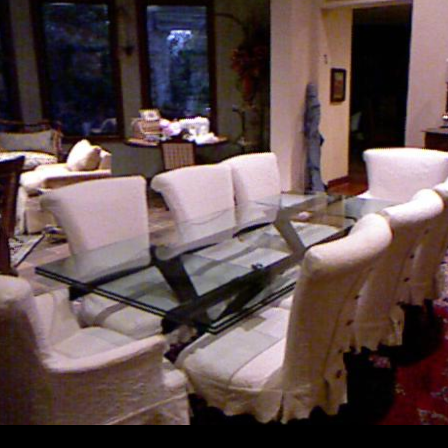

In [31]:
img

In [28]:
ques = tokenizer.tokenize('how many chairs are in the image')
ques = tokenizer.convert_tokens_to_ids(ques)
ques

[2129, 2116, 8397, 2024, 1999, 1996, 3746]

In [32]:
img = np.array(img, dtype=np.uint8) / 255
img = np.moveaxis(img, -1, 0)

ques = torch.tensor(ques).unsqueeze(0).to(device)
img = torch.from_numpy(img).unsqueeze(0).float().to(device)

out = model(img, ques)

In [33]:
out

tensor([[-10.0959, -10.1048, -10.0597,  ..., -10.1024, -10.0518,  -0.6110]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [34]:
index = np.argmax(out.detach().cpu().numpy())
index

1016

In [35]:
tokenizer.convert_ids_to_tokens([index])

['2']

###### Get the dataset

In [16]:
%%capture
! wget http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/nyu_depth_images.tar

In [17]:
%%capture
! tar -xvf nyu_depth_images.tar

In [18]:
! find . -name image3.png

./nyu_depth_images/image3.png


In [19]:
# Image.open('./nyu_depth_images/image3.png')

In [20]:
%%capture
! wget https://raw.githubusercontent.com/jayantk/lsp/master/data/daquar/reduced/qa.37.raw.train.txt

Rough

In [21]:
x_seq = [torch.tensor([5, 18, 29]), torch.tensor([32, 100]), torch.tensor([699, 6, 9, 17])]
x_padded = pad_sequence(x_seq, batch_first=True, padding_value=0)

In [22]:
x = torch.randn(2, 3)
print(f'{x.size()}')

# add more rows (thus increasing the dimensionality of the column space to 2 -> 6)
xnew_from_cat = torch.stack((x, x, x), 0)
print(f'{xnew_from_cat.size()}')

torch.Size([2, 3])
torch.Size([3, 2, 3])


In [23]:
out = torch.rand((2, 9000))
ans = torch.randint(0, 3, (2,))
out.shape, ans.shape

(torch.Size([2, 9000]), torch.Size([2]))

In [24]:
nn.CrossEntropyLoss()(out, ans)

tensor(9.2734)

In [25]:
x = torch.rand(10, 196, 1)

In [26]:
F.softmax(x, dim=1).sum(dim=1)

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]])